### Load 2D data file in SASView

run using .venv (Python 3.12.10) on laptop

import all the packages

In [1]:
import numpy as np

# import sasmodels
import sasmodels
import sasmodels.core
import sasmodels.data
import sasmodels.bumps_model

import sasdata

from sasdata.dataloader.loader import Loader
from sasmodels.data import load_data
#from sas import sascalc.dataloader

from sasmodels.data import plot_theory

import bumps
import bumps.fitters
import bumps.names
import bumps.fitproblem

import os



In [2]:

"""
import matplotlib.pyplot and set custom default settings for plots
"""
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


import matplotlib.pyplot as plt
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg')

plt.rc('font', size=14) # default fontsize
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)
plt.rc('legend', title_fontsize=14)
plt.rc('figure', titlesize=18)
plt.rc("figure", figsize=(5,5))
plt.rc("lines", linewidth=3)

#import tol_colors as tc # colorblind safe color palettes

# use colorblind safe colors:
#plt.rc('axes', prop_cycle=plt.cycler('color', list(tc.tol_cset('muted'))))
#try:
#    plt.cm.register_cmap('tc_iridescent', tc.tol_cmap('iridescent'))
#except:
#    pass

#plt.rc('image', cmap='tc_iridescent')

#plt.rc('image', cmap='rainbow')
plt.rc('image', cmap='jet')



### file selection

* 'less_aligned_Nika.h5' was generated in Igor with Nika (CanSAS format)
* 'less_aligned_ROI.h5' was generated from the same file in SASView GUI using 'savepoints as a file' and selecting the .h5 format
* other possibility is a .dat format

TO DO:
* do the same with the 'less_aligned_Nika.h5' file

In [3]:
filename="./images/25%_Nika.h5"

### data loader method

In [4]:
data2d=sasmodels.data.load_data(filename)

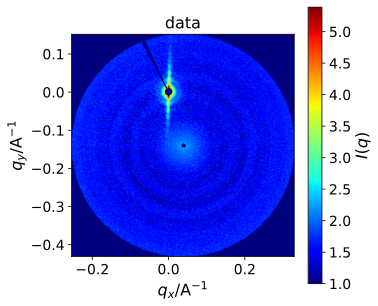

In [5]:
sasmodels.data.plot_data(data2d)

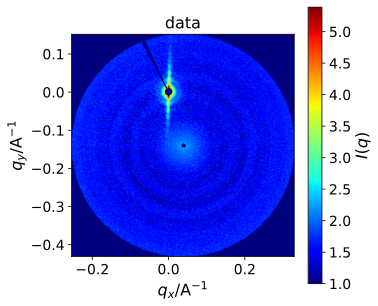

In [6]:
sasmodels.data.plot_data(data2d,view='log')

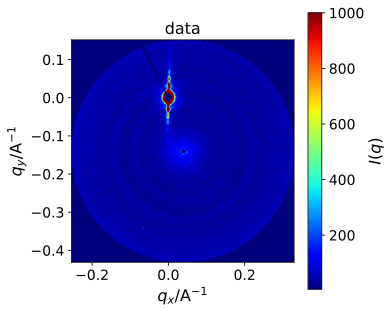

In [ ]:
#sasmodels.data.plot_data(data2d,view='linear',limits=[5,1000])

* store in I_all, qx_all and qy_all

In [8]:
I_all=data2d.data
qx_all=data2d.qx_data
qy_all=data2d.qy_data

* rebuilt a data set

In [9]:
data_all = sasmodels.data.Data2D(x=qx_all, y=qy_all, z=I_all,dx=None,dy=None,dz=None)

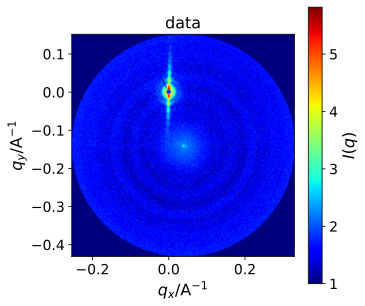

In [10]:
sasmodels.data.plot_data(data_all)

### reduce the number of data points before fiting

TO DO: add a circle in the middle to exclude the beamstop region

* create a numpy array
* ROI with qmqx_x and qmax_y
* errors proportionnal to intensity values (usually 10%)

In [166]:
number_all=I_all.shape[0]

data_np=[]

error_coeff=0.1
error_min=0.0000001

#ROI
qmax_x=0.025
qmax_y=0.14

#exclude a circle around the beamstop

q_center=0.012

for i in range(number_all):
    if (-qmax_x)<qx_all[i]<qmax_x and (-qmax_y)<qy_all[i]<qmax_y and (qx_all[i]**2+qy_all[i]**2)>q_center**2:
#        print(I_all[i])
        data_np.append([qx_all[i],qy_all[i],I_all[i],error_min+error_coeff*I_all[i]])

data_np=np.array(data_np) 

size=data_np.shape[0]

print(size)

101416


* slicing to reduce evennmore the number of points

In [167]:
slicing=20

data_reduced = sasmodels.data.Data2D(x=data_np[0:size:slicing,0], 
                                     y=data_np[0:size:slicing,1], 
                                     z=data_np[0:size:slicing,2],
                                     dx=None,dy=None,
                                     dz=data_np[0:size:slicing,3])


size_reduced=data_np[0:size:slicing,0].shape[0]
print(size_reduced)

5071


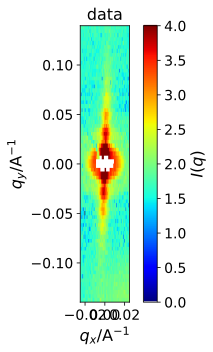

In [168]:
sasmodels.data.plot_data(data_reduced,view="log",limits=[1,10000])

estimation of background value

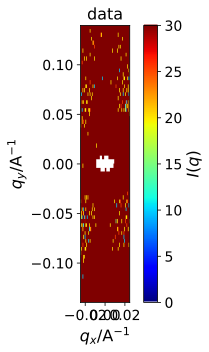

In [169]:
sasmodels.data.plot_data(data_reduced,view="linear",limits=[0,30])

### fiting of the reduced set of data points in the image

* choice of the cylinder model 
* can be replaced by any other model !

In [170]:
kernel = sasmodels.core.load_model("cylinder")
params = {} # default parameters for now
model = sasmodels.bumps_model.Model(kernel, **params)
experiment = sasmodels.bumps_model.Experiment(data=data_reduced, model=model)

first manual adjustement of different parameters

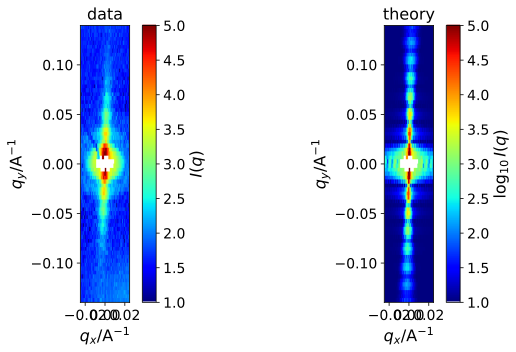

In [172]:
params = {
    "phi": -1, "theta": 80,
    "phi_pd_type": 'gaussian', #polydispersity function
    "phi_pd": 1.5, #polydispersity
    "phi_pd_n": 30, #number of steps in polydispersity
    "phi_pd_nsigma": 3, #range of polydispersity    
    "radius": 170,
    "radius_pd_type": 'gaussian', #number of steps in polydispersity
    "radius_pd": 0.02, #polydispersity
    "radius_pd_n": 8, #number of steps in polydispersity
    "radius_pd_nsigma": 4, #range of polydispersity
    "length":10000,
    "background": 10,
    "scale": 10
}
model = sasmodels.bumps_model.Model(model=kernel, **params)
experiment = sasmodels.bumps_model.Experiment(data=data_reduced, model=model)

plt.figure(figsize=(10,5))

#experiment.plot()

plot_theory(data_reduced,experiment.theory(),view="log",limits=[10,100000])

* choice of the initial values for parameters
* choice of the fiting parameters with their fiting range

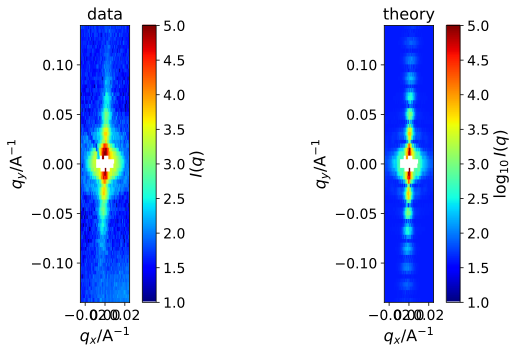

In [187]:
params = {
    "phi": -1.0, 
    "theta": 90,

    "phi_pd_type": 'gaussian', #polydispersity function
    "phi_pd": 2, #polydispersity
    "phi_pd_n": 40, #number of steps in polydispersity
    "phi_pd_nsigma": 4, #range of polydispersity 

#    "theta_pd_type": 'gaussian', #polydispersity function
#    "theta_pd": 10, #polydispersity
#    "theta_pd_n": 40, #number of steps in polydispersity
#    "theta_pd_nsigma": 4, #range of polydispersity 

    "theta_pd_type": 'uniform', #polydispersity function
    "theta_pd": 180, #polydispersity

    "radius": 170,
    #"radius_pd_type": 'gaussian', #number of steps in polydispersity
    #"radius_pd": 0.02, #polydispersity
    #"radius_pd_n": 40, #number of steps in polydispersity
    #"radius_pd_nsigma": 4, #range of polydispersity

    "length":10000,

    "background": 40,
    "scale": 2
}

model = sasmodels.bumps_model.Model(model=kernel, **params)

#list of the fiting parameters with their fiting range
model.scale.range(1,10)
#model.background.range(0.1,50)

model.phi.range(-4,2)
#model.theta.range(80,110)

model.phi_pd.range(1, 10)
#model.theta_pd.range(51, 10)

#model.radius.range(150,200)
#model.radius_pd.range(0,0.2)

experiment = sasmodels.bumps_model.Experiment(data=data_reduced, model=model)

plt.figure(figsize=(10,5))
#experiment.plot()
plot_theory(data_reduced,experiment.theory(),view="log",limits=[10,100000])

* creation of the fit `problem` 
* `problem` is generated by FitProblem in bump module
* RUN the fit problem

step 1 cost 33343453763873.11719(70)
                                     phi ....|.....         -1 in [-4, 2]
                                  phi_pd .|........          2 in [1, 10]
                                   scale .|........          2 in [1, 10]
step 2 cost 32365883982504.39062(70)
step 3 cost 32171485848168.46875(70)
step 4 cost 32149439182352.41797(70)
step 5 cost 32148733619777.86328(70)
step 5 cost 32148732193742.39062(70) [final]
                                     phi .......|..   0.308639 in [-4, 2]
                                  phi_pd |.........          1 in [1, 10]
                                   scale |.........          1 in [1, 10]
time 17.2 seconds
final chisq 32148732193742.39062(70)
=== Uncertainty from curvature:     name   value(unc.) ===
                                     phi   0.3086(88)     
                                  phi_pd   1.0000(70)     
                                   scale   1.0000(22)     


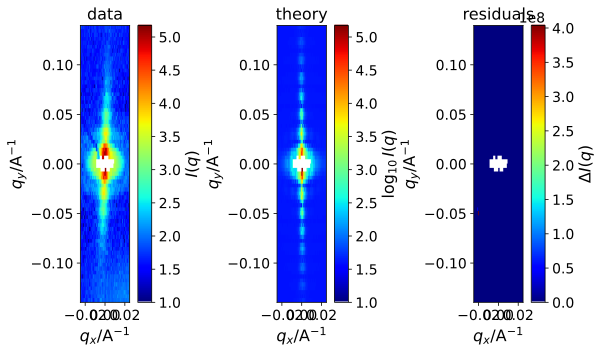

In [175]:
problem = bumps.fitproblem.FitProblem(experiment)

results = bumps.fitters.fit(problem, method='lm',steps=20, ftol=1.5e-08, xtol=1.5e-08, verbose=True)

plt.figure(figsize=(10, 5))
experiment.plot()

In [176]:
print(problem.model_parameters())

{'models': [{'scale': Parameter(scale), 'background': Parameter(background), 'sld': Parameter(sld), 'sld_solvent': Parameter(sld_solvent), 'radius': Parameter(radius), 'radius_pd': Parameter(radius_pd), 'radius_pd_n': Parameter(radius_pd_n), 'radius_pd_nsigma': Parameter(radius_pd_nsigma), 'length': Parameter(length), 'length_pd': Parameter(length_pd), 'length_pd_n': Parameter(length_pd_n), 'length_pd_nsigma': Parameter(length_pd_nsigma), 'theta': Parameter(theta), 'theta_pd': Parameter(theta_pd), 'theta_pd_n': Parameter(theta_pd_n), 'theta_pd_nsigma': Parameter(theta_pd_nsigma), 'phi': Parameter(phi), 'phi_pd': Parameter(phi_pd), 'phi_pd_n': Parameter(phi_pd_n), 'phi_pd_nsigma': Parameter(phi_pd_nsigma), 'up_frac_i': Parameter(up_frac_i), 'up_frac_f': Parameter(up_frac_f), 'up_theta': Parameter(up_theta), 'up_phi': Parameter(up_phi), 'sld_M0': Parameter(sld_M0), 'sld_mtheta': Parameter(sld_mtheta), 'sld_mphi': Parameter(sld_mphi), 'sld_solvent_M0': Parameter(sld_solvent_M0), 'sld_solv

In [177]:
print(problem.summarize())

                                     phi .......|..   0.308639 in [-4, 2]
                                  phi_pd |.........          1 in [1, 10]
                                   scale |.........          1 in [1, 10]


In [178]:
print(problem.chisq())

32148732193742.39


### plot after fiting

labels of the fiting parameters

In [179]:
problem.labels()

['phi', 'phi_pd', 'scale']

fited values of the parameters

In [180]:
results.x

array([0.30863943, 1.        , 1.        ])

error of the fited values

In [181]:
results.dx

array([0.00876075, 0.00701735, 0.00216782])

In [182]:
model.phi.value

0.3086394343115365

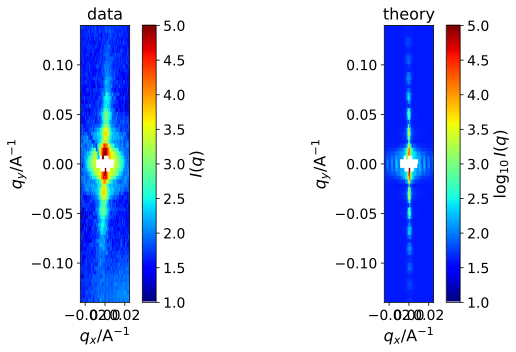

In [183]:
params = {
    "phi": model.phi.value, 
    "theta": model.theta.value,

    "phi_pd_type": 'gaussian', #polydispersity function
    "phi_pd": model.phi_pd.value, #polydispersity
    "phi_pd_n": 30, #number of steps in polydispersity
    "phi_pd_nsigma": 3, #range of polydispersity  

    "radius": model.radius.value,
#    "radius_pd_type": 'gaussian', #number of steps in polydispersity
#    "radius_pd": 0.1, #polydispersity
#    "radius_pd_n": 8, #number of steps in polydispersity
#    "radius_pd_nsigma": 4, #range of polydispersity
    "length":model.length.value,
    "background": model.background.value,
    "scale": model.scale.value
}

model = sasmodels.bumps_model.Model(model=kernel, **params)
experiment = sasmodels.bumps_model.Experiment(data=data_reduced, model=model)

plt.figure(figsize=(10,5))
#experiment.plot()
plot_theory(data_reduced,experiment.theory(),view="log",limits=[10,100000])



In [39]:
problem.fitness.theory()

c:\Users\IMPÉROR\CloudStation\dev-SASView\.venv\Lib\site-packages\bumps\fitproblem.py:305: UserWarning: Deprecated: use of problem.fitness will be removed at some point
  warnings.warn("Deprecated: use of problem.fitness will be removed at some point")


array([35.38878913, 34.95296932, 35.42674115, ..., 35.30863583,
       34.94774033, 35.40191479], shape=(3881,))

### cylinder model and orientation distribution:
* [cylinder model and angles](https://www.sasview.org/docs/user/models/cylinder.html)
* Angles θ and ϕ orient the cylinder relative to the beam line coordinates, where the beam is along the z axis. Rotation θ, initially in the xz plane, is carried out first, then rotation ϕ about the z axis. 
* Orientation distributions are described as rotations about two perpendicular axes δ1 and δ2 in the frame of the cylinder itself, which when θ=ϕ=0 are parallel to the Y and X axes.
* <img src="https://www.sasview.org/docs/_images/cylinder_angle_definition.png">
* <img src="https://www.sasview.org/docs/_images/cylinder_angle_projection.png">

### bumps for fiting
The default optimizer for the bumps fit is the Levenberg-Marquardt method, but there are many available as described in greater detail in the Bumps [documentation](https://bumps.readthedocs.io/en/latest/guide/optimizer.html) with additional fitting options.

For Levenberg-Marquardt, the steps, f(x) tolerance and x tolerance from the GUI options can be set with the `steps`, `ftol` and `xtol` arguments in the `fit` method.

<img src="https://bumps.readthedocs.io/en/latest/_images/fit-lm.png">

*Image source: https://bumps.readthedocs.io/en/latest/guide/optimizer.html*

### Explanation of the polydispersity parameters

The polydispersity is set using a special set of \*\_pd\_\* parameters:
* `*_pd*` is the width of the polydispersity and the exact definition will depend on the type of distribution specified; in this cause of a 'gaussian` distribution, it is defined as as $\frac{\sigma}{x_{mean}}$
* `*_pd_type*` defines the type of polydispersity distribution used
* `*_pd_n` corresponds to the the number of points in the distribution used by the calculation (Npts in the image below)
* `*_pd_nsigma` sets the range of the distribution sampled (Nsigmas in the image below)

For example, radius polydispersity could be defined by specifying **all four** of the pd parameters. With the default values, this would look like:
* `radius_pd = 0`
* `radius_pd_type = 'gaussian'`
* `radius_pd_n = 35`
* `radius_pd_nsigma = 3`

The available polydispersity distributions are defined in the SasView [documentation](https://www.sasview.org/docs/user/qtgui/Perspectives/Fitting/pd/polydispersity.html) but we can access them directly through the sasmodels `weights` module.

The 'gaussian' distribution is calculated by:

$$
f(x) = \frac{1}{Norm}\exp\left(-\frac{(x-x_{mean})^2}{2\sigma^2}\right)
$$

<img src=https://www.sasview.org/docs/_images/pd_gaussian.jpg>

*Image source: https://www.sasview.org/docs/user/qtgui/Perspectives/Fitting/pd/polydispersity.html*
